<a href="https://colab.research.google.com/github/erinmcmahon26/Chatbot/blob/main/second_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import json
import random
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout

from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [3]:
df = pd.read_json('https://raw.githubusercontent.com/erinmcmahon26/Chatbot/main/zelda.json', orient = 'index')

In [4]:
df.head()

,0
The Legend of Zelda: Breath of the Wild,The Legend of Zelda: Breath of the Wild is a 2...
Untitled The Legend of Zelda: Breath of the Wild sequel,An untitled sequel to the 2017 action-adventur...
The Legend of Zelda,The Legend of Zelda is a high fantasy action-a...
Universe of The Legend of Zelda,The Legend of Zelda is a video game franchise ...
Hyrule Warriors: Age of Calamity,Hyrule Warriors: Age of Calamity is a hack-and...


In [5]:
df.reset_index(inplace = True)

In [6]:
df.rename(columns = {'index':'doc_title', 0:'doc_text'}, inplace = True)

In [7]:
df.head()

,doc_title,doc_text
0,The Legend of Zelda: Breath of the Wild,The Legend of Zelda: Breath of the Wild is a 2...
1,Untitled The Legend of Zelda: Breath of the Wi...,An untitled sequel to the 2017 action-adventur...
2,The Legend of Zelda,The Legend of Zelda is a high fantasy action-a...
3,Universe of The Legend of Zelda,The Legend of Zelda is a video game franchise ...
4,Hyrule Warriors: Age of Calamity,Hyrule Warriors: Age of Calamity is a hack-and...


In [8]:
df['doc_title']

0               The Legend of Zelda: Breath of the Wild
1     Untitled The Legend of Zelda: Breath of the Wi...
2                                   The Legend of Zelda
3                       Universe of The Legend of Zelda
4                      Hyrule Warriors: Age of Calamity
5                                                Urbosa
6                       List of Game of the Year awards
7                                        Princess Zelda
8                                                 Mipha
9                            Link (The Legend of Zelda)
10                                         Prince Sidon
11                                      Nintendo Switch
12                                    Horizon Zero Dawn
13                                       Genshin Impact
14                                 The Game Awards 2017
15                                 Hidemaro Fujibayashi
16                                      Sonic Frontiers
17                                              

In [10]:
#delete docs not related to video game
df.drop([12, 13, 16, 24, 29])

,doc_title,doc_text
0,The Legend of Zelda: Breath of the Wild,The Legend of Zelda: Breath of the Wild is a 2...
1,Untitled The Legend of Zelda: Breath of the Wi...,An untitled sequel to the 2017 action-adventur...
2,The Legend of Zelda,The Legend of Zelda is a high fantasy action-a...
3,Universe of The Legend of Zelda,The Legend of Zelda is a video game franchise ...
4,Hyrule Warriors: Age of Calamity,Hyrule Warriors: Age of Calamity is a hack-and...
5,Urbosa,Urbosa is a fictional character from Nintendo'...
6,List of Game of the Year awards,Game of the Year (GotY) is an award given by v...
7,Princess Zelda,Princess Zelda is the titular character in Nin...
8,Mipha,Mipha is a fictional character in Nintendo's T...
9,Link (The Legend of Zelda),Link is a fictional character and the protagon...


In [11]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = stopwords.words('english')
    stop_words = set(stop_words)
    tokens = [w for w in tokens if not w in stop_words]         
    # lemmatize
    wnl = WordNetLemmatizer()
    tokens=[wnl.lemmatize(word.lower()) for word in tokens]
    return tokens

In [12]:
df['tokens'] = df['doc_text'].apply(lambda x: clean_doc(x))

In [13]:
df.head()

,doc_title,doc_text,tokens
0,The Legend of Zelda: Breath of the Wild,The Legend of Zelda: Breath of the Wild is a 2...,"[legend, zelda, breath, actionadventure, devel..."
1,Untitled The Legend of Zelda: Breath of the Wi...,An untitled sequel to the 2017 action-adventur...,"[untitled, sequel, actionadventure, legend, ze..."
2,The Legend of Zelda,The Legend of Zelda is a high fantasy action-a...,"[legend, zelda, fantasy, actionadventure, vide..."
3,Universe of The Legend of Zelda,The Legend of Zelda is a video game franchise ...,"[legend, zelda, video, franchise, created, jap..."
4,Hyrule Warriors: Age of Calamity,Hyrule Warriors: Age of Calamity is a hack-and...,"[hyrule, warrior, calamity, hackandslash, vide..."


In [44]:
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    inbound = bagofwords.fit_transform(data)
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    print(words_rank.head(10))
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10], palette = 'inferno')
    plt.title(title)
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


      word  count
8993   the   9366
6127    of   4577
587    and   3502
4553    in   3257
9098    to   3085
4821    is   1365
5273  link   1348
3771  game   1348
787     as   1345
8992  that   1175


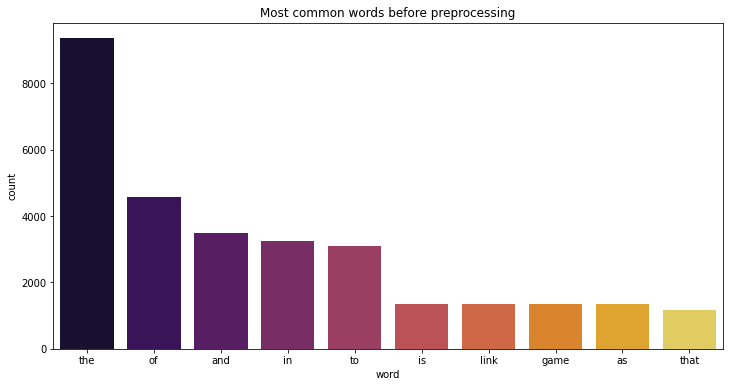

In [45]:
top10_bagofwords(df['doc_text'], 'most_common', 'Most common words before preprocessing')

In [46]:
#hmmmm why does it not like .lower.....
top10_bagofwords(df['tokens'], 'most_common', "Top 10 most common words after preprocessing")

AttributeError: ignored